In [6]:
from PIL import Image
import os

base_path = r"C:\Users\ram_k\Downloads\GAN25_Detect_Training_Data_Usage_tr\ImageCLEF25_GAN_Detect_Training_Data_Usage_training-dataset"
image_dirs = ["generated", "real_used", "real_not_used"]  # List of folders

for img_dir in image_dirs:
    img_folder = os.path.join(base_path, img_dir)
    
    for img_name in os.listdir(img_folder):
        img_path = os.path.join(img_folder, img_name)
        
        # Open the image and convert it if necessary
        with Image.open(img_path) as img:
            if img.mode == "P":  # Convert palette images to RGBA
                img = img.convert("RGBA")
            img.load()  # Ensure it's fully loaded

print("All images processed successfully!")


All images processed successfully!


In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ResNet50 model for feature extraction
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
model.to(device).eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract deep features from images
def extract_features(image_path):
    image = Image.open(image_path).convert('RGBA')  # Convert to RGBA to avoid transparency issues
    image = image.convert('RGB')  # Remove alpha channel safely
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().cpu().numpy().flatten()

# Define dataset paths
base_path = r"C:\Users\ram_k\Downloads\GAN25_Detect_Training_Data_Usage_tr\ImageCLEF25_GAN_Detect_Training_Data_Usage_training-dataset"

real_used_path = os.path.join(base_path, "real_used")
real_not_used_path = os.path.join(base_path, "real_not_used")
generated_path = os.path.join(base_path, "generated")

# Check if dataset exists
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Base directory does not exist: {base_path}")

# Ensure subdirectories exist
for path in [real_used_path, real_not_used_path, generated_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing directory: {path}")

# Function to process image folder and extract features
def process_images(folder_path):
    features_dict = {}
    images = os.listdir(folder_path)
    for img_name in tqdm(images, desc=f"Processing {folder_path}"):
        img_path = os.path.join(folder_path, img_name)
        try:
            features_dict[img_name] = extract_features(img_path)
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    return features_dict

# Extract features for real images
print("Extracting features from real_used images...")
real_used_features = process_images(real_used_path)

print("Extracting features from real_not_used images...")
real_not_used_features = process_images(real_not_used_path)

# Compare synthetic images with real images
results = []

print("Comparing generated images with real_used and real_not_used images...")
for synth_img in tqdm(os.listdir(generated_path)):
    synth_path = os.path.join(generated_path, synth_img)
    try:
        synth_features = extract_features(synth_path)

        # Compute similarity with real_used images
        used_similarities = [cosine_similarity([synth_features], [feat])[0][0] for feat in real_used_features.values()]
        
        # Compute similarity with real_not_used images
        not_used_similarities = [cosine_similarity([synth_features], [feat])[0][0] for feat in real_not_used_features.values()]

        # Handle empty lists safely
        max_used_similarity = max(used_similarities) if used_similarities else 0
        max_not_used_similarity = max(not_used_similarities) if not_used_similarities else 0

        # Dynamically determine threshold using mean + std deviation
        similarity_values = used_similarities + not_used_similarities
        threshold = np.mean(similarity_values) + 0.5 * np.std(similarity_values) if similarity_values else 0.9

        # Label as "used" (1) if similarity to used images is significantly higher
        is_used = int(max_used_similarity > max_not_used_similarity and max_used_similarity > threshold)
        
        results.append([synth_img, max_used_similarity, max_not_used_similarity, threshold, is_used])
    except Exception as e:
        print(f"Skipping {synth_img} due to error: {e}")

# Save results to CSV
df = pd.DataFrame(results, columns=['Generated Image', 'Max Used Similarity', 'Max Not Used Similarity', 'Threshold', 'Used in Training'])
df.to_csv("training_data_usage_results.csv", index=False)

print("✅ Detection Completed. Results saved to 'training_data_usage_results.csv'")


Using device: cpu
Extracting features from real_used images...


Processing C:\Users\ram_k\Downloads\GAN25_Detect_Training_Data_Usage_tr\ImageCLEF25_GAN_Detect_Training_Data_Usage_trai


Extracting features from real_not_used images...


Processing C:\Users\ram_k\Downloads\GAN25_Detect_Training_Data_Usage_tr\ImageCLEF25_GAN_Detect_Training_Data_Usage_trai


Comparing generated images with real_used and real_not_used images...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [35:43<00:00,  2.33it/s]

✅ Detection Completed. Results saved to 'training_data_usage_results.csv'


In [2]:
!pip install torch torchvision torchaudio


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\ram_k\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
    --------------------------------------- 4.7/204.2 MB 25.9 MB/s eta 0:00:08
   -- ------------------------------------- 10.5/204.2 MB 25.1 MB/s eta 0:00:08
   -- ------------------------------------- 14.7/204.2 MB 23.6 MB/s eta 0:00:09
   --- ------------------------------------ 16.5/204.2 MB 20.4 MB/s eta 0:00:10
   --- ------------------------------------ 17.3/204.2 MB 16.8 MB/s eta 0:00:12
   --- ------------------------------------ 18.6/204.2 MB 14.5 MB/s eta 0:00:13
   --- ------------------------------------ 20.2/204.2 MB 13.6 MB/s eta 0:00:14
   ---- ----------------------------------- 22.5/204.2 MB 13.2 MB/s eta 0:00:14
   ----- ---------------------------------- 25.7/204.2 MB 13.3 MB/s eta 0:00:14
   ----- ---------------------------------- 28.8/204.2 MB 13.5 MB/s eta 0:00:13
   ------ --------------------------------- 32.0/204.2 MB 13.6 MB/s eta 0:00:13
   ------ --------------------------------- 35.4/

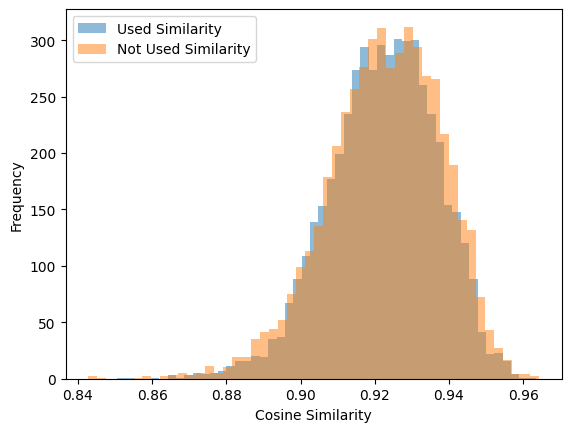

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("training_data_usage_results.csv")

plt.hist(df['Max Used Similarity'], bins=50, alpha=0.5, label="Used Similarity")
plt.hist(df['Max Not Used Similarity'], bins=50, alpha=0.5, label="Not Used Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


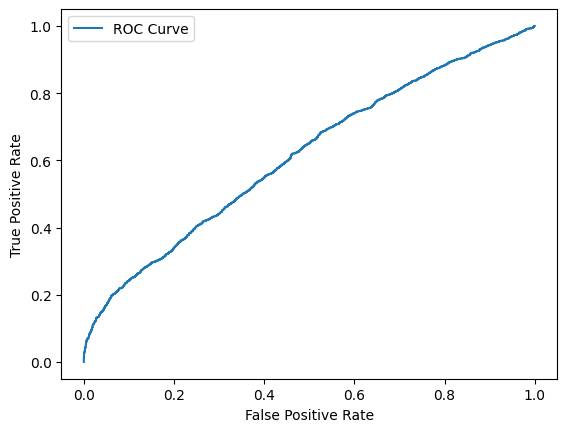

In [10]:
from sklearn.metrics import roc_curve

y_true = df["Used in Training"]  # Actual labels
y_scores = df["Max Used Similarity"]  # Similarity scores

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [11]:
print(f"Total Images Analyzed: {len(df)}")
print(f"Percentage Marked as Used: {df['Used in Training'].mean() * 100:.2f}%")
print(f"Average Used Similarity: {df['Max Used Similarity'].mean():.4f}")
print(f"Average Not Used Similarity: {df['Max Not Used Similarity'].mean():.4f}")


Total Images Analyzed: 5000
Percentage Marked as Used: 49.38%
Average Used Similarity: 0.9222
Average Not Used Similarity: 0.9226


In [12]:
from sklearn.linear_model import LogisticRegression

X = df[['Max Used Similarity', 'Max Not Used Similarity']]
y = df['Used in Training']

model = LogisticRegression()
model.fit(X, y)
print(f"Model Accuracy: {model.score(X, y):.4f}")


Model Accuracy: 0.8288


In [13]:
import os
print(os.path.abspath("training_data_usage_results.csv"))


C:\Users\ram_k\training_data_usage_results.csv


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# Define features and target
X = df[['Max Used Similarity', 'Max Not Used Similarity']]
y = df['Used in Training']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Precision: 0.8738
Recall: 0.7743
F1 Score: 0.8211


In [18]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 0.8349


In [19]:
!pip install seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\ram_k\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


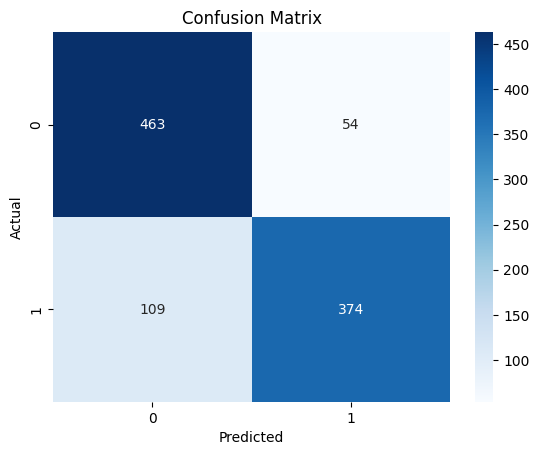

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
